# MDAnalysis
The notebook is full centered on the MDAnlysis of a sample of water, in which the atom type 1 is the Hydrogen, while the atom type is the Oxygen. 

In [25]:
import ase
from ase import Atoms
from ase.io import read,write
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
import maicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
# Load the LAMMPS dump file and extract the first frame
# It will be used subsequently to create the topology in the MDAnalysis universe
starting_structure = read("Data/Simulations/dump_NVT.lammpstrj", index="0",format = "lammps-dump-text")
starting_structure.write("Data/Simulations/starting_configuration.xyz") 

In [27]:
# Create the Universe
u = mda.Universe("Data/Simulations/starting_configuration.xyz", "Data/Simulations/dump_NVT.lammpstrj",  topology_format="XYZ", format="LAMMPSDUMP", atom_style="id type element x y z vx vy vz")

/home/forina/Documents/Simulations/Analysis/MDAnalysis/mdaenv/lib/python3.12/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt


In [28]:
# Check of the statistics of the Universe
print("Number of atoms in the Universe: ", u.atoms.n_atoms)
print("Number of frames in the Universe: ", u.trajectory.n_frames)
print(f"Trajectory: {u.trajectory}  & Dimension of the system: {u.dimensions}")
print(f"Starting Universe Density: {starting_structure.get_masses().sum() * 1.66054e-24/ (15 * 15*15 * 1.0e-24)} [g]/[cm^3].") #in g/cm^3 


Number of atoms in the Universe:  327
Number of frames in the Universe:  5001
Trajectory: <DumpReader Data/Simulations/dump_NVT.lammpstrj with 5001 frames of 327 atoms>  & Dimension of the system: [15. 15. 15. 90. 90. 90.]
Starting Universe Density: 0.9661316927111113 [g]/[cm^3].


In [29]:
# Here we separate the Universe in two groups: one for the hydrogen and one for the oxygen.
hydrogen = u.select_atoms("element H", updating = True)
oxygen = u.select_atoms("element O", updating = True)
print(f"The total number of H atoms is {len(hydrogen)}")
print(f"The total number of O atoms is {len(oxygen)}")


The total number of H atoms is 218
The total number of O atoms is 109


In [30]:
# In this section we will calculate the RDF for the whole trajectory.
rdf__OO = InterRDF(oxygen, oxygen, nbins=200, range=(0, u.dimensions[:3].min()/2))
rdf__HH = InterRDF(hydrogen, hydrogen, nbins=200, range=(0, u.dimensions[:3].min()/2))
rdf__OH = InterRDF(oxygen, hydrogen, nbins=200, range=(0, u.dimensions[:3].min()/2))
rdf__OO.run(start= 100, verbose=True)
rdf__HH.run(start= 100, verbose=True)
rdf__OH.run(start= 100, verbose=True)

# Here are also saved the reference data for the RDF
OO = pd.read_csv("Data/Experimental/OO.csv", header=None, names=["r", "G(r)"])
OH = pd.read_csv("Data/Experimental/OH.csv", header=None, names=["r", "G(r)"])
HH = pd.read_csv("Data/Experimental/HH.csv", header=None, names=["r", "G(r)"])


100%|██████████| 4901/4901 [00:11<00:00, 409.13it/s]


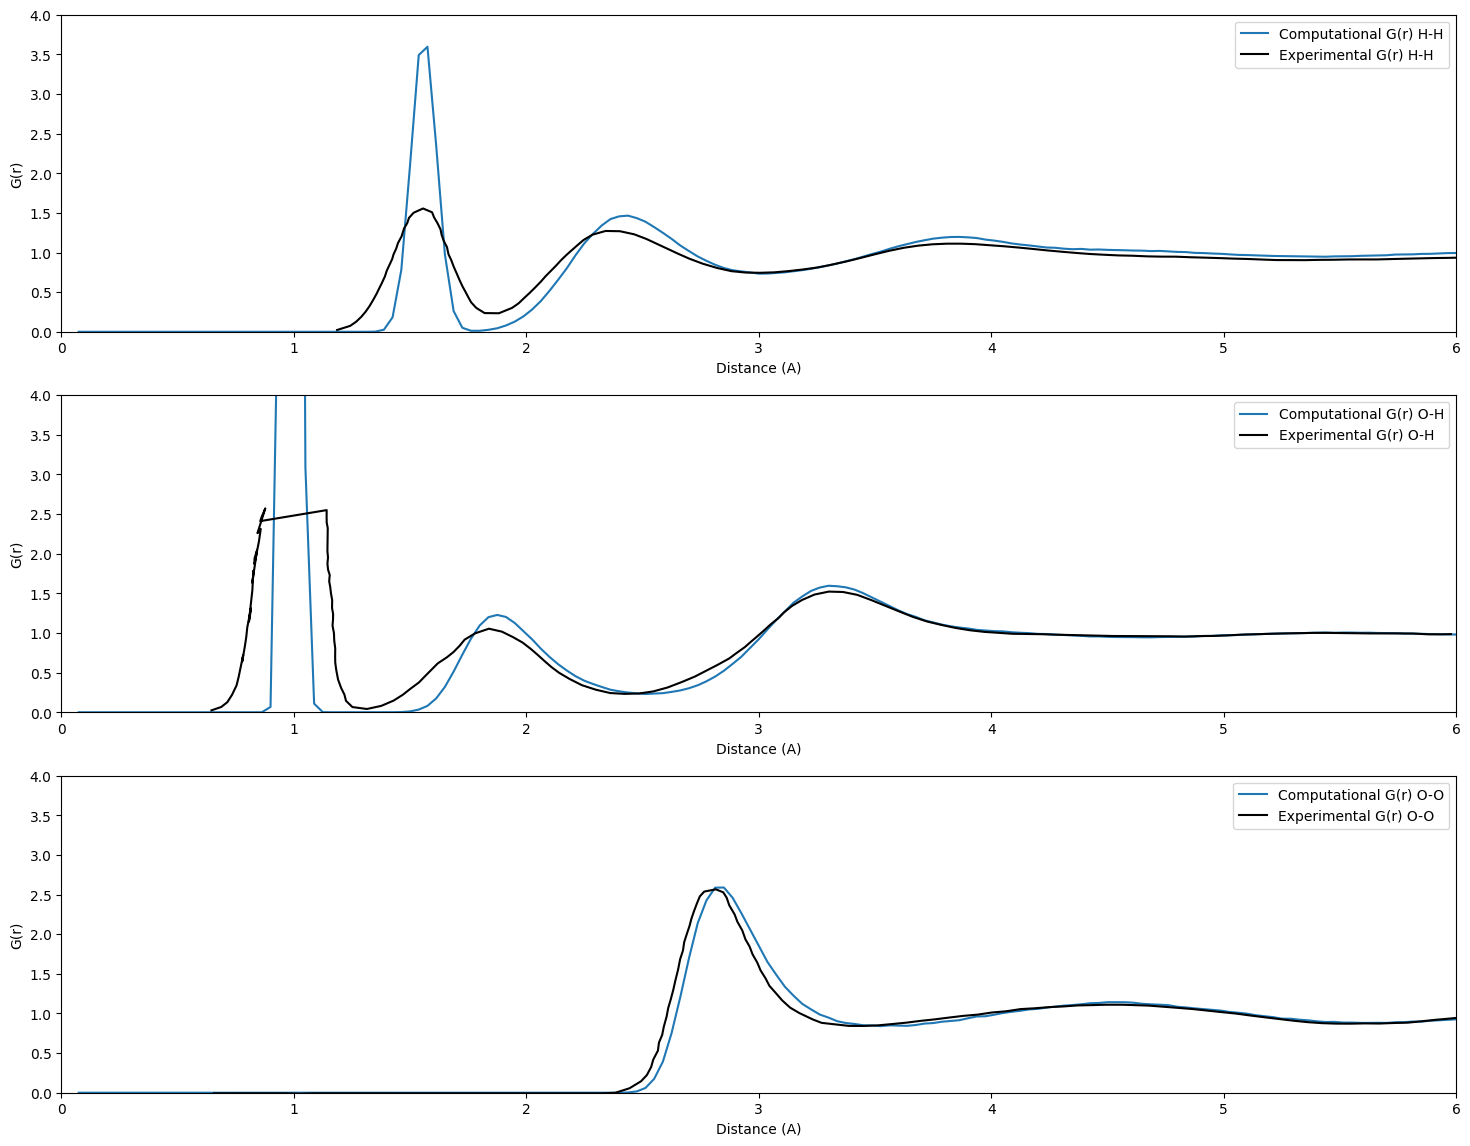

In [31]:
fig, ax = plt.subplots(3, figsize=(18, 14))

ax[0].plot(rdf__HH.results.edges[2:], rdf__HH.results.rdf[1:], label="Computational G(r) H-H")
ax[0].plot(HH["r"], HH["G(r)"], linestyle="-", label="Experimental G(r) H-H", color="black")

ax[1].plot(rdf__OH.results.edges[2:], rdf__OH.results.rdf[1:], label="Computational G(r) O-H")
ax[1].plot(OH["r"], OH["G(r)"], linestyle="-", label="Experimental G(r) O-H", color="black")

ax[2].plot(rdf__OO.results.edges[2:], rdf__OO.results.rdf[1:], label="Computational G(r) O-O")
ax[2].plot(OO["r"], OO["G(r)"], linestyle="-", label="Experimental G(r) O-O", color="black")
for a in ax:    
    a.set_xlabel("Distance (A)")
    a.set_ylabel("G(r)")
    a.set_ylim(0,4)
    a.set_xlim(0, 6)
    a.legend()
fig.savefig("Comparison.png")
plt.show()